In [1]:
import sys
sys.path.append('../')

import msgpack
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import OrderedDict
from astropy import units as u
from astropy import constants as const
from typing import Union, Dict, Optional
from gerador import pypsg

In [18]:
def converter_configuracao(configuracao: Union[Dict, str], para_dataframe: bool = True) -> Union[pd.DataFrame, str]:
    """
    Converte uma configuração de string para DataFrame ou vice-versa.

    Args:
        configuracao (Union[Dict, str]): Configuração a ser convertida.
        para_dataframe (bool, optional): Se True, converte para DataFrame. 
        Se False, converte para string.

    Raises:
        ValueError: Se o tipo de dado da configuração não for suportado para conversão.

    Returns:
        Union[pd.DataFrame, str]: Configuração convertida.
    """
    if isinstance(configuracao, str):
        if para_dataframe:
            config_dict = {chave.strip("<"): [valor.strip()] 
                           for linha in configuracao.split("\n") if linha.strip() 
                           for chave, valor in [linha.split(">", 1)]}
            return pd.DataFrame(config_dict)
        else:
            return configuracao
    elif isinstance(configuracao, dict):
        if para_dataframe:
            return pd.DataFrame.from_dict(configuracao, orient="index").T
        else:
            return "\n".join([f"<{chave}>{valor}" for chave, valor in configuracao.items()])
    else:
        raise ValueError("Tipo de dado não suportado para conversão")

class EspectroAnalise:
    """
    Classe base para análise de espectros.

    Esta classe fornece métodos para analisar espectros, incluindo a conversão de espectros para DataFrames pandas,
    a plotagem de espectros e a exibição de cabeçalhos de resultados de espectros.
    """
    
    def __init__(self, resultado: Dict) -> None:
        """
        Inicializa a classe com um resultado de espectro.
        
        Args:
            resultado (Dict): Um dicionário contendo o resultado do espectro.
        """
        self._resultado = resultado
        self._configurar_matplotlib()
    
    def _configurar_matplotlib(self) -> None:
        """
        Configura os parâmetros do matplotlib.
        """
        plt.rcParams.update({
            "axes.spines.right": False,
            "axes.spines.top": False,
            "font.size": 12,
            "axes.labelsize": 12,
            "axes.titlesize": 12,
            "legend.fontsize": 10,
            "xtick.labelsize": 10,
            "ytick.labelsize": 10,
            "figure.figsize" : (10, 4)
            })

    def mostrar_cabecalho(self) -> Optional[str]:
        """
        Mostra o cabeçalho do resultado do espectro.

        Este método retorna o cabeçalho do resultado do espectro. Se nenhum cabeçalho estiver disponível,
        ele retornará "Nenhum cabeçalho disponível".

        Returns:
            str: O cabeçalho do resultado do espectro ou uma mensagem indicando que nenhum cabeçalho está disponível.
        """
        cabecalho = self._resultado.get("header", "Nenhum cabeçalho disponível")
        return cabecalho
    
    def converter_para_dataframe(self) -> pd.DataFrame:
        """
        Converte o espectro em um DataFrame pandas.
        
        Este método converte o espectro, que é uma lista de listas, em um DataFrame pandas. As colunas do DataFrame
        são "Wave/freq [um]", "Total [I/F apparent albedo]", "Noise", "Stellar", "Planet".
        
        Returns:
            pd.DataFrame: Um DataFrame contendo o espectro.
        """
        try:
            espectro = self._resultado.get("spectrum", [])
            if len(espectro[0]) == 5:
                colunas = ["Wave/freq [um]", "Total [I/F apparent albedo]", "Noise", "Stellar", "Planet"]
            else:
                colunas = ["Wave/freq [um]", "Total [I/F apparent albedo]", "Noise", "Planet"]
            return pd.DataFrame(espectro, columns=colunas)
        except:
            try:
                cabecalho = self.mostrar_cabecalho()
                texto_apos_pumas = cabecalho.split('PUMAS |', 1)[1].strip()
                texto = texto_apos_pumas.split('#', 1)[0].strip()
                print("Opa! Aqui retornou esse erro:", texto)
            except IndexError:
                print("O número de colunas excedeu o necessário!")
            except Exception as e:
                print("Ocorreu um erro ao processar o cabeçalho:", e)
            
    def plotar_espectro(self, cor_linha: str = "tab:blue", ax = None, label: str = None) -> plt.Axes:
        """
        Plota o espectro.

        Este método plota o espectro usando matplotlib. Ele plota "Wave/freq [um]" no eixo x 
        e "Total [I/F apparent albedo]" no eixo y.

        Parâmetros:
        cor_linha (str, optional): Cor da linha do gráfico. Padrão é "tab:blue".
        ax (matplotlib.axes._axes.Axes, optional): Eixo em que o gráfico será plotado. Se None, cria um novo eixo. Padrão é None.
        label (str, optional): Rótulo do gráfico para a legenda. Padrão é None.

        Retorna:
        matplotlib.axes._axes.Axes: O eixo onde o gráfico foi plotado.
        """
        espectro_df = self.converter_para_dataframe()

        if isinstance(espectro_df, pd.core.frame.DataFrame):
            try:
                wave_freq = espectro_df["Wave/freq [um]"]
                total_albedo = espectro_df["Total [I/F apparent albedo]"]

                if ax is None:
                    _, ax = plt.subplots()

                ax.plot(wave_freq, total_albedo, color = cor_linha, lw = 1, label = label)
                ax.set(xlabel="Comprimento de onda [$\mu$m]", ylabel="Albedo aparente")

                return ax
            except IndexError:
                print("O número de colunas excedeu o necessário!")
            except Exception as e:
                print("Ocorreu um erro ao plotar o espectro:", e)

def modifica_valor_gas(dicionario: dict, gas: str, multiplicador: float) -> None:
    """
    Modifica os valores de gás em um dicionário ordenado.

    Parâmetros:
    dicionario (dict): O dicionário ordenado contendo os valores de gás.
    gas (str): O gás a ser modificado: 'H2O', 'CO2', 'O3', 'N2O', 'CO', 'CH4', 'O2', 'NO', 'SO2', 'NO2', 
    'NH3', 'HNO3', 'OH','HF', 'HCl', 'HBr', 'HI', 'ClO', 'OCS', 'H2CO', 'HOCl', 'N2', 'HCN', 'CH3Cl', 'H2O2',
    'C2H2', 'C2H6', 'PH3'
    multiplicador (float): O fator pelo qual modificar o valor do gás.

    Retorna:
    None: O dicionário ordenado é modificado in-place.
    """
    indice_gas = None
    elementos = ['H2O', 'CO2', 'O3', 'N2O', 'CO', 'CH4', 'O2', 'NO', 'SO2', 'NO2', 'NH3', 'HNO3', 'OH', 
                 'HF', 'HCl', 'HBr', 'HI', 'ClO', 'OCS', 'H2CO', 'HOCl', 'N2', 'HCN', 'CH3Cl', 'H2O2', 
                 'C2H2', 'C2H6', 'PH3']
    try:
        indice_gas = elementos.index(gas)
    except ValueError:
        print("Gás não encontrado na lista de elementos.")
        return

    for key, value in dicionario.items():
        if key.startswith("ATMOSPHERE-LAYER-"):
            values = value.split(',')
            valor_gas = float(values[indice_gas + 2])
            if multiplicador == 0:
                novo_valor = 0
            else:
                novo_valor = valor_gas * (1 + 1/ multiplicador)
            values[indice_gas + 2] = str(novo_valor)
            dicionario[key] = ','.join(values)

def modifica_pressao_atmosferica(dicionario: dict, valor: float) -> None:
    """
    Modifica o valor da pressão atmosférica.

    Parâmetros:
    dicionario (dict): O dicionário ordenado.
    valor (float): O novo valor da pressão atmosférica em mbar.

    Retorna:
    None: O dicionário ordenado é modificado in-place.
    """
    dicionario["ATMOSPHERE-PRESSURE"] = str(valor)
    return

def modifica_telescopio(dicionario: dict) -> None:
    """
    Modifica as configurações do telescópio em um dicionário de entrada (HabEx_HWC-Spec - The HabEx Workforce Camera )

    Parâmetros:
    dicionario (dict): Dicionário de configurações a ser modificado.

    Retorna:
    None
    """

    dicionario['GENERATOR-INSTRUMENT'] = """
    HabEx_HWC-Spec: The HabEx Workforce Camera (HWC) has two channels that can simultaneously observe the same field of view: 
    an optical channel using delta-doped CCD detectors providing access from 370 nm to 950 nm (QE:0.9), and a near-IR channel 
    using Hawaii-4RG HgCdTe (QE:0.9) arrays providing good throughput from 950 µm to 1.8 µm. The imaging mode can provide 
    spectroscopy (RP<10) via filters at high-throughput, while a grating delivering RP=1000 is assumed to reduce the throughput 
    by 50%.
    """
    dicionario['GENERATOR-RANGE1'] = 0.37
    dicionario['GENERATOR-RANGE2'] = 1.80
    dicionario['GENERATOR-RESOLUTION'] = 1000
    dicionario['GENERATOR-TELESCOPE'] = "SINGLE"
    dicionario['GENERATOR-TELESCOPE1'] = 1
    dicionario['GENERATOR-TELESCOPE2'] = 2.0
    dicionario['GENERATOR-TELESCOPE3'] = 1.0
    dicionario['GENERATOR-NOISEOTEMP'] = 250
    dicionario['GENERATOR-NOISEOEFF'] = '0.000@0.325,0.003@0.337,0.016@0.348,0.067@0.353,0.183@0.365,0.222@0.370,0.240@0.381,\
        0.251@0.401,0.273@0.421,0.302@0.454,0.312@0.508,0.302@0.620,0.283@0.714,0.258@0.793,0.248@0.836,0.261@0.905,0.280@0.955, \
            0.287@1.004,0.295@1.131,0.302@1.291,0.314@1.426,0.321@1.561,0.330@1.693,0.335@1.800'
    dicionario['GENERATOR-NOISEFRAMES'] = 10
    dicionario['GENERATOR-NOISETIME'] = 0   # Aqui usando o tempo de exposição = 0
    dicionario['GENERATOR-NOISEPIXELS'] = 8
    dicionario['GENERATOR-CONT-STELLAR'] = 'Y'

def config_aleatorio(dicionario: dict, mod_telescopio: bool = False) -> None:
    """
    Modifica aleatoriamente as configurações de um dicionário de entrada com base em vários parâmetros.

    Parâmetros:
    dicionario (dict): Dicionário de configurações a ser modificado.
    mod_telescopio (bool): Se True, modifica as configurações do telescópio. Padrão é False.

    Retorna:
    None
    """
    # Modifica o tipo espectral da estrela
    tipo_espectral = ['U', 'G', 'K', 'M']
    classe_estrela =  tipo_espectral[np.random.randint(0, len(tipo_espectral))]

    dicionario['OBJECT-STAR-TYPE'] = classe_estrela         # Classe da estrela
    dicionario['GEOMETRY-STELLAR-TYPE'] = classe_estrela    # Classe da estrela de ocultação

    # Modifica o raio e a temperatura da estrela
    # Fonte: A Modern Mean Dwarf Stellar Color and Effective Temperature Sequence (2019)
    # https://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.dat
    if classe_estrela == 'U':                               # Isso é tipo F -- usa modelo de corpo negro
        temp_estrela = round(np.random.uniform(6000, 7220), 3)
        raio_estrela = round(np.random.uniform(1.18, 1.79), 3)
    elif classe_estrela == 'G':
        temp_estrela = round(np.random.uniform(5340, 5920), 3)
        raio_estrela = round(np.random.uniform(0.876, 1.12), 3)
    elif classe_estrela == 'K':
        temp_estrela = round(np.random.uniform(3940, 5280), 3)
        raio_estrela = round(np.random.uniform(0.552, 0.817), 3)
    elif classe_estrela == 'M':
        temp_estrela = round(np.random.uniform(2320, 3870), 3)
        raio_estrela = round(np.random.uniform(0.104, 0.559), 3)

    dicionario['OBJECT-STAR-RADIUS'] = raio_estrela             
    dicionario['OBJECT-STAR-TEMPERATURE'] = temp_estrela        
    dicionario['GEOMETRY-STELLAR-TEMPERATURE'] = temp_estrela  

    # Gera a longitude sub solar em graus
    longitude = np.random.uniform(-360, 360)
    dicionario['OBJECT-SOLAR-LONGITUDE']  = longitude   

    # Gera a latitude sub solar em graus
    latitude = np.random.uniform(-90, 90)
    dicionario['OBJECT-SOLAR-LATITUDE']   = latitude    

    # Pressão atmosférica em mbar
    pressao = round(np.random.uniform(500, 1500), 3)
    dicionario["ATMOSPHERE-PRESSURE"] = str(pressao)

    # Modificando os mixings ratio
    gases = ['H2O','CO2','O3','N2O','CO','CH4','O2','N2']
    
    for gas in gases:
        multiplicador = np.random.uniform(0.3, 3)                # Intervalo aleatório de multiplicadores
        if np.random.random() < 0.3:                             # Probabilidade de 30% de definir o multiplicador como zero
            multiplicador = 0.0
        modifica_valor_gas(dicionario, gas, multiplicador)
    
    pesos_molares = np.array([
        18.01528,   # H2O
        44.0095,    # CO2
        47.9982,    # O3
        44.0128,    # N2O
        28.0101,    # CO
        16.0425,    # CH4
        31.9988,    # O2
        30.0061,    # NO
        64.066,     # SO2
        46.0055,    # NO2
        17.0305,    # NH3
        63.0129,    # HNO3
        17.0073,    # OH
        20.0063,    # HF
        36.4609,    # HCl
        80.9119,    # HBr
        127.912,    # HI
        51.45,      # ClO
        60.075,     # OCS
        30.026,     # H2CO
        52.46,      # HOCl
        28.0134,    # N2
        27.0253,    # HCN
        50.4875,    # CH3Cl
        34.0147,    # H2O2
        26.0373,    # C2H2
        30.069,     # C2H6
        33.9976     # PH3
        ])

    somas = []

    for i in range(50):
        valores = dicionario[f"ATMOSPHERE-LAYER-{i+1}"].split(',')[2:]
        soma_multiplicacao = sum(float(valor) * peso_molecular for valor, peso_molecular in zip(valores, pesos_molares))
        somas.append(soma_multiplicacao)

    peso_molecular_medio = round(np.mean(somas), 2)
    dicionario['ATMOSPHERE-WEIGHT'] = peso_molecular_medio    # Peso molecular da atmosfera [g/mol]

    ## Modificando o Semi-eixo maior (AU) para estar dentro da zona de habitabilidade
    # Fonte: Habitable zones around main-sequence stars... (Kopparapu et al. 2013) 
    # https://iopscience.iop.org/article/10.1088/0004-637X/765/2/131/pdf
    # Equações 2, 3 e Tabela 3 de Kopparapu et al. 2013
    temp = temp_estrela - 5780

    # Lei de Stefan-Boltzmann para a luminosidade! 
    # https://arxiv.org/abs/2402.07947
    luminosidade_estrela = 4 * np.pi * ((raio_estrela) ** 2) * const.sigma_sb.value * temp_estrela ** 4
    
    # Recent Venus (limite inferior) - Tabela 3 (primeira coluna)
    S_eff_odot = 1.7753
    a = 1.4316e-4
    b = 2.9875e-9
    c = -7.5702e-12
    d = -1.1635e-15
    S_eff_inferior = S_eff_odot + a * temp + b * temp ** 2 + c * temp ** 3 + d * temp ** 4

    # Early Mars (limite superior) - Tabela 3 (segunda coluna)
    S_eff_odot = 0.3179
    a = 5.4513e-5
    b = 1.5313e-9
    c = -2.7786e-12
    d = -4.8997e-16
    S_eff_superior = S_eff_odot + a * temp + b * temp ** 2 + c * temp ** 3 + d * temp ** 4

    # Distância da zona de habitabilidade (Equação 3)
    a_inferior = ((luminosidade_estrela / const.L_sun.value) / S_eff_inferior) ** 0.5
    a_superior = ((luminosidade_estrela / const.L_sun.value) / S_eff_superior) ** 0.5

    # Colocando  o planeta em algum lugar desse range...
    a = np.random.uniform(a_inferior, a_superior)
    dicionario['OBJECT-STAR-DISTANCE'] = a

    ## Modificando a metalicidade da estrela de forma aleatória
    # Motivação e fonte: High metallicity and non-equilibrium chemistry... (Madhusudhan1 e Seager 2011)
    # https://iopscience.iop.org/article/10.1088/0004-637X/729/1/41/meta
    # 10x maior e menor a metalicidade do sol (em dex)
    dicionario['OBJECT-STAR-METALLICITY'] = round(np.random.uniform(-1, 1), 3)

    if mod_telescopio:
        modifica_telescopio(dicionario)
    return

## Primeiro Teste - Carregando arquivo de configuração do HWO para Terra moderna

In [4]:
with open("../gerador/config/default_habex.config", "rb") as f:
    config = OrderedDict(msgpack.unpack(f, raw=False))
config_df = converter_configuracao(config)

In [14]:
api_user = "https://10.2.180.164/api.php"
psg = pypsg.PSG(timeout_seconds = 200)

Testing connection to PSG at https://psg.gsfc.nasa.gov/api.php ...
Connected to PSG with success.


In [19]:
modifica_telescopio(config)     # HabEx Workforce Camera (HWC)
resultado = psg.run(config)
spectrum = EspectroAnalise(resultado)

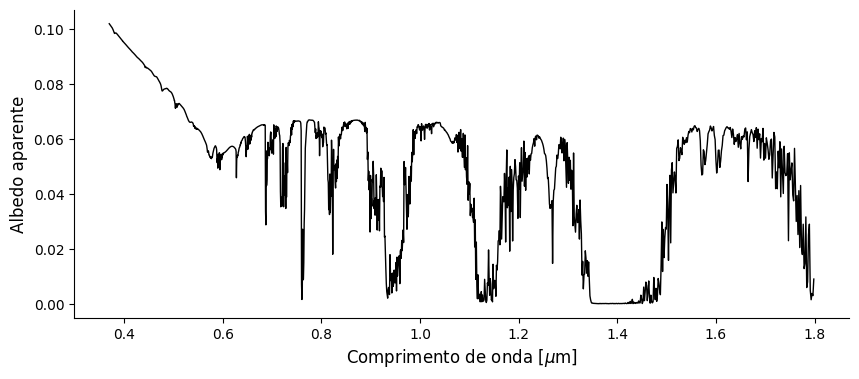

In [20]:
spectrum.plotar_espectro(cor_linha = "k");

## Teste 2 - Mudando as abundâncias

In [21]:
# Dobrando o valor de O2
config_dobro_O2 = config.copy()
modifica_telescopio(config_dobro_O2) 
modifica_valor_gas(config_dobro_O2, "O2", 2)
resultado_dobro_O2 = psg.run(config_dobro_O2)

In [22]:
# Tirando O2 da atmosfera
config_sem_O2 = config.copy()
modifica_telescopio(config_sem_O2) 
modifica_valor_gas(config_sem_O2, "O2", 0)
resultado_sem_O2 = psg.run(config_sem_O2)

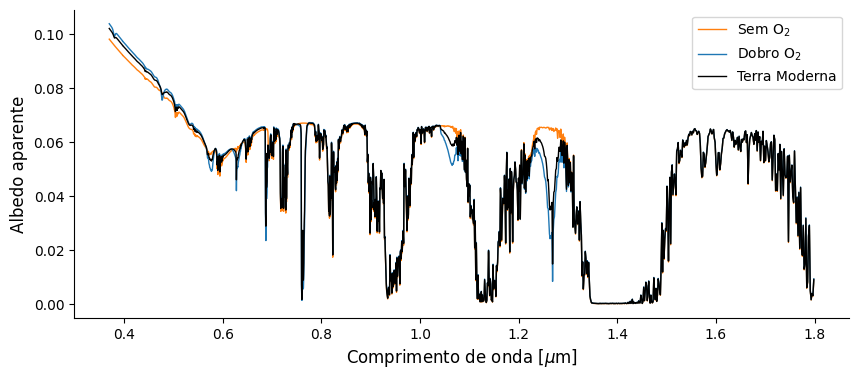

In [23]:
spectrum_dobro_02 = EspectroAnalise(resultado_dobro_O2)
spectrum_sem_02 = EspectroAnalise(resultado_sem_O2)

_, ax = plt.subplots()
spectrum_sem_02.plotar_espectro(ax = ax, label = "Sem O${}_2$", cor_linha = "tab:orange")
spectrum_dobro_02.plotar_espectro(ax = ax, label = "Dobro O${}_2$", cor_linha = "tab:blue")
spectrum.plotar_espectro(ax=ax, label="Terra Moderna", cor_linha = "k")
ax.legend();

## Teste 3 - Modificando a pressão atmosférica (mbar)

In [24]:
# 500 mbar = .5 bar
# O espectro não retornou nada para o dobro e 4x a pressão atmosférica
config_metade_atm = config.copy()
modifica_pressao_atmosferica(config_metade_atm, 500)
modifica_telescopio(config_metade_atm) 
resultado_metade_atm = psg.run(config_metade_atm)

config_15_atm = config.copy()
modifica_pressao_atmosferica(config_15_atm, 1500)
modifica_telescopio(config_15_atm) 
resultado_15_atm = psg.run(config_15_atm)

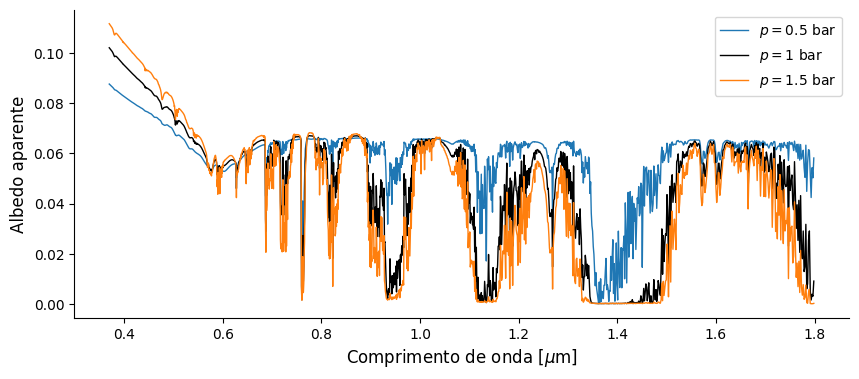

In [25]:
spectrum_metade_atm = EspectroAnalise(resultado_metade_atm)
spectrum_15_atm = EspectroAnalise(resultado_15_atm)

_, ax = plt.subplots()
spectrum_metade_atm.plotar_espectro(ax = ax, label = "$p = 0.5$ bar", cor_linha = "tab:blue")
spectrum.plotar_espectro(ax=ax, label = "$p = 1$ bar", cor_linha = "black")
spectrum_15_atm.plotar_espectro(ax = ax, label = "$p = 1.5$ bar", cor_linha = "tab:orange")
ax.legend();

Quando a pressão atmosférica diminui, é geralmente um indicativo de uma atmosfera mais rarefeita. Em contrapartida, uma pressão atmosférica mais elevada sugere uma atmosfera mais densa e expansiva. A correlação entre a densidade atmosférica e a visibilidade das assinaturas espectrais está intrinsecamente ligada à interação fóton-molécula. Em uma atmosfera densa, as moléculas presentes têm mais oportunidades de interagir com os fótons, resultando em assinaturas espectrais mais pronunciadas. No entanto, quando a atmosfera é mais rarefeita, essas interações diminuem, levando a uma atenuação significativa das assinaturas espectrais.

## Geração de modelos

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


O número de colunas excedeu o necessário!


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


O número de colunas excedeu o necessário!


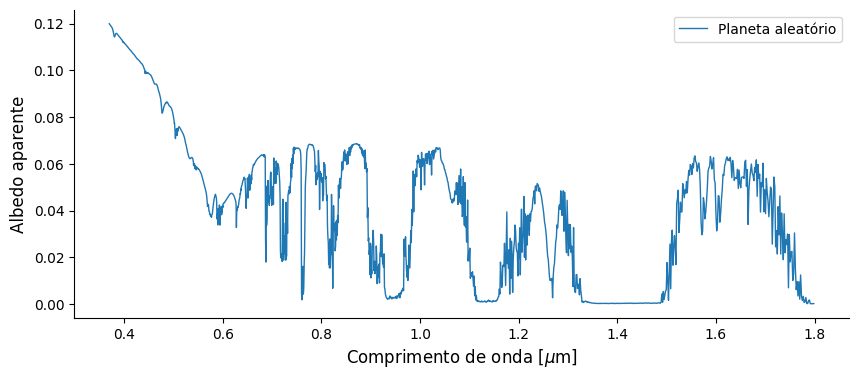

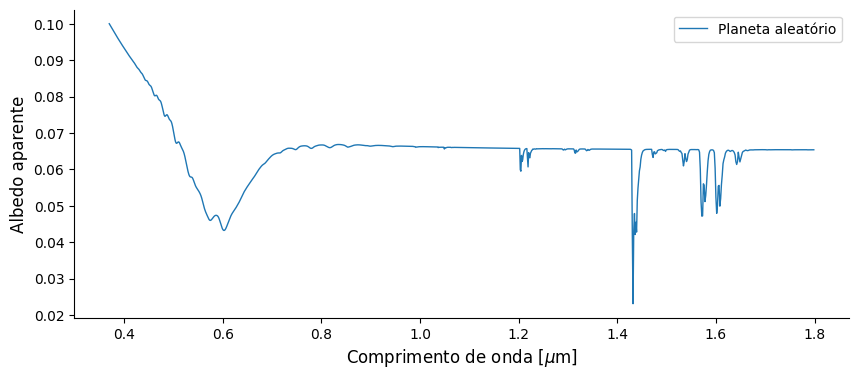

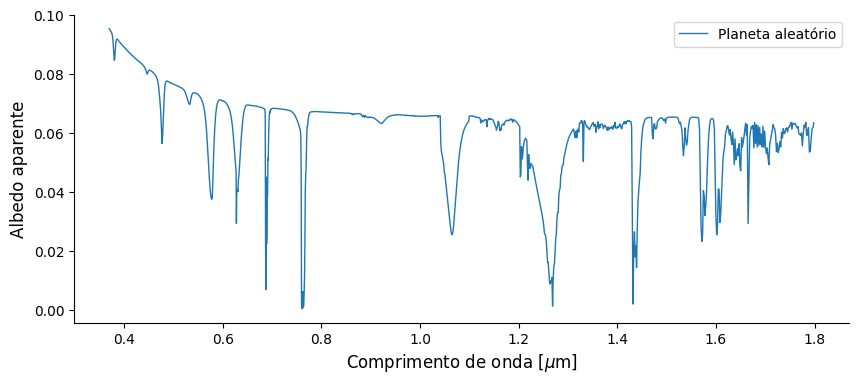

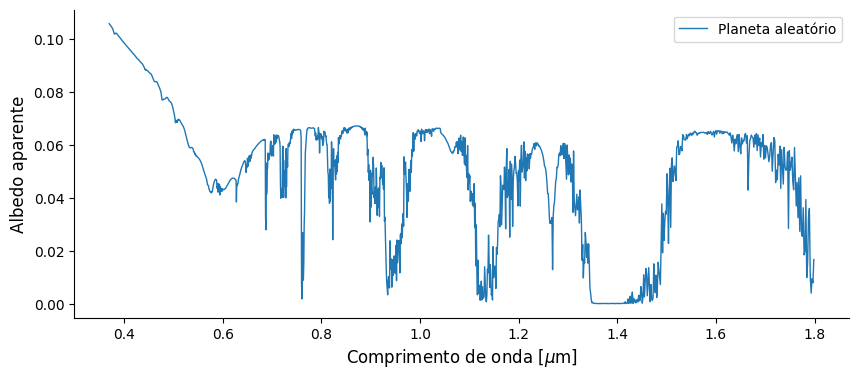

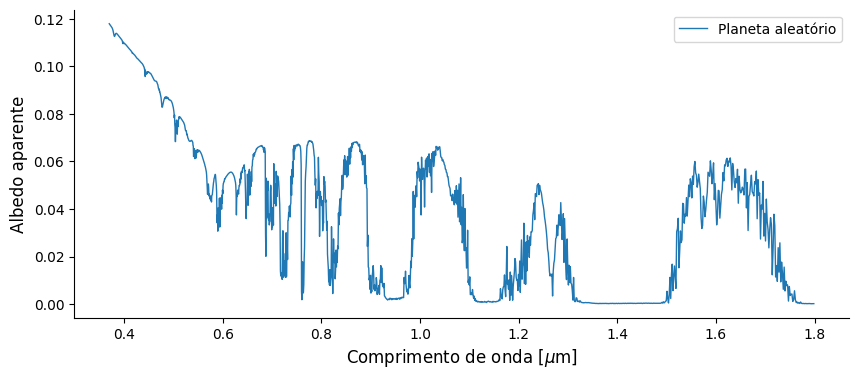

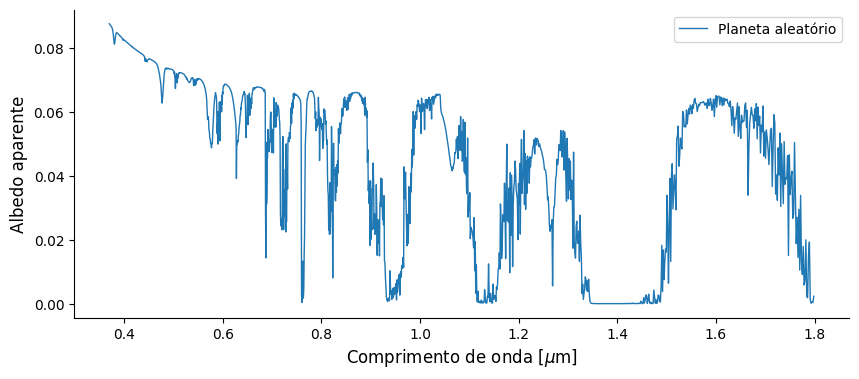

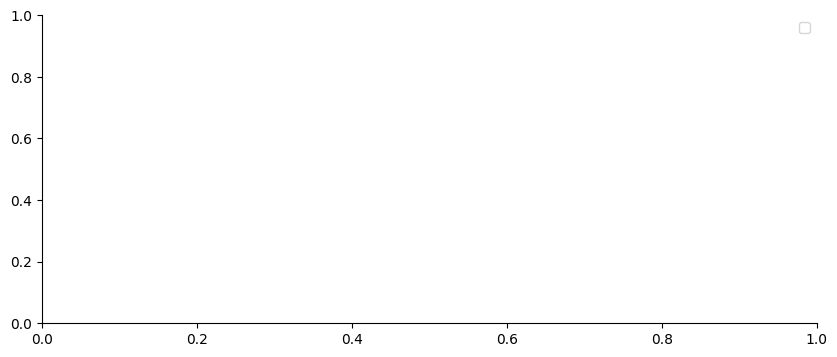

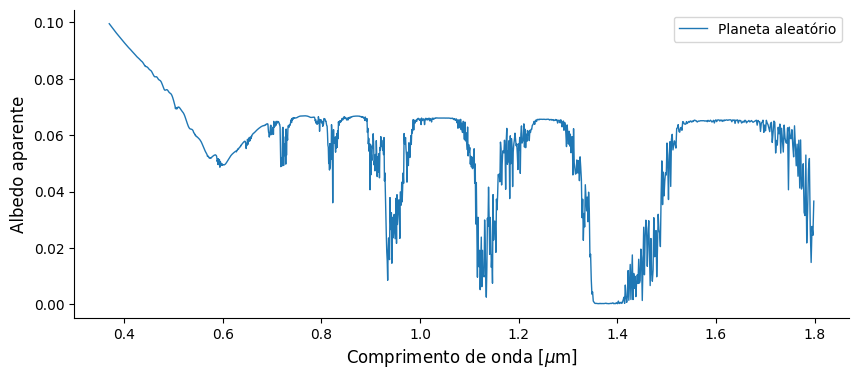

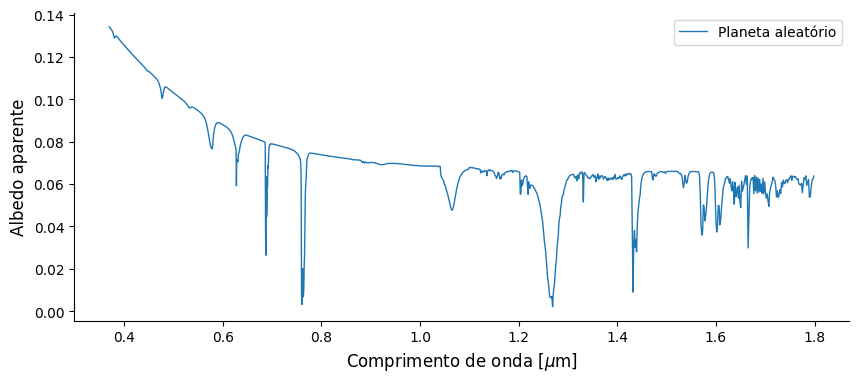

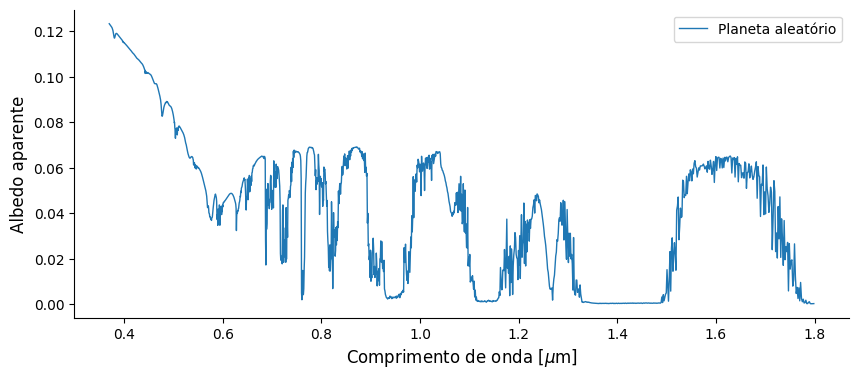

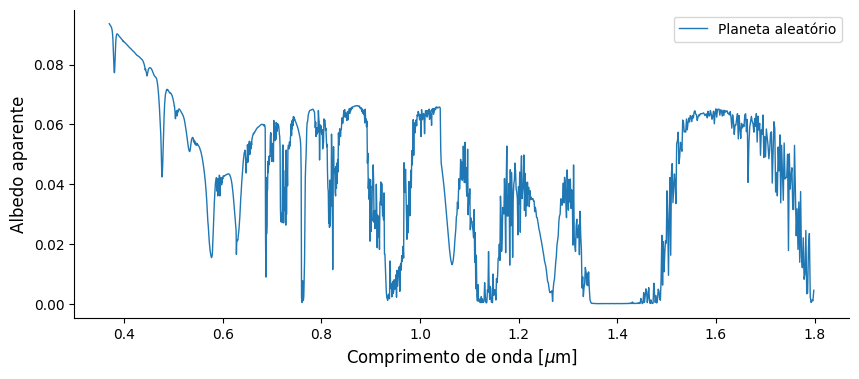

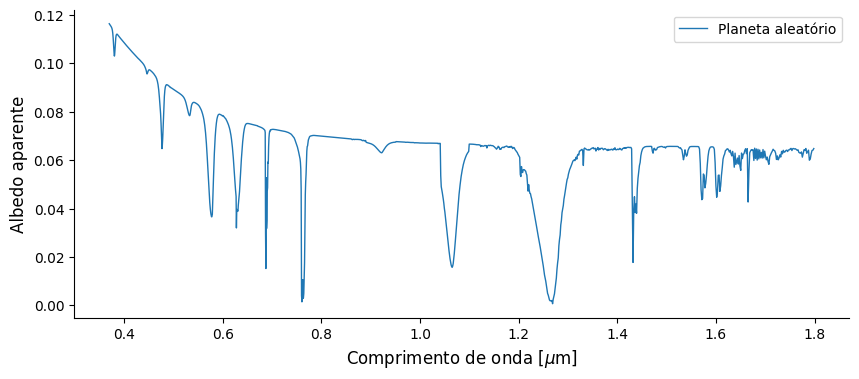

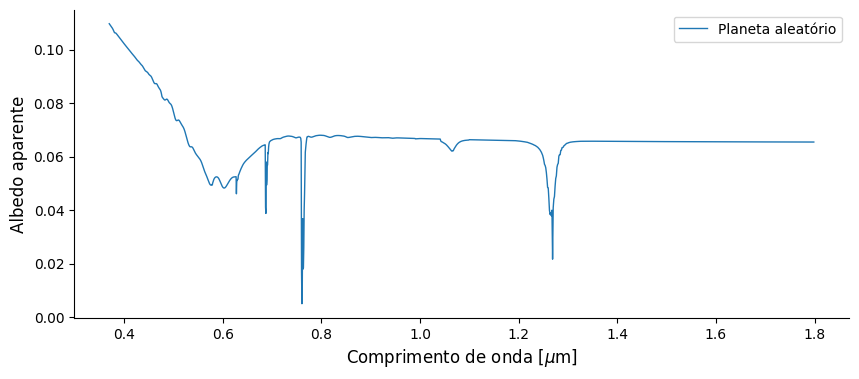

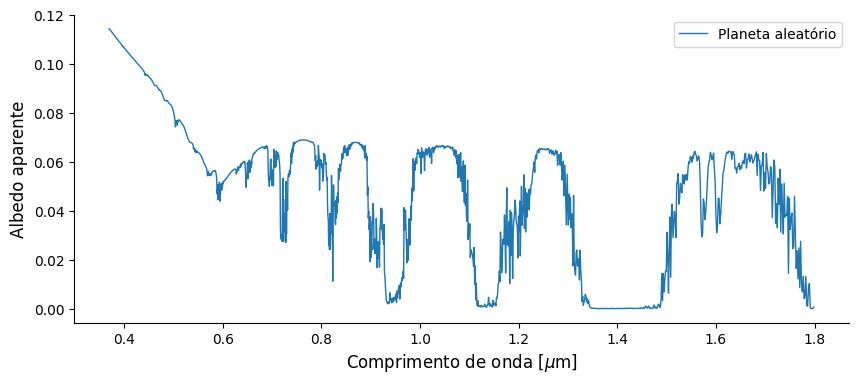

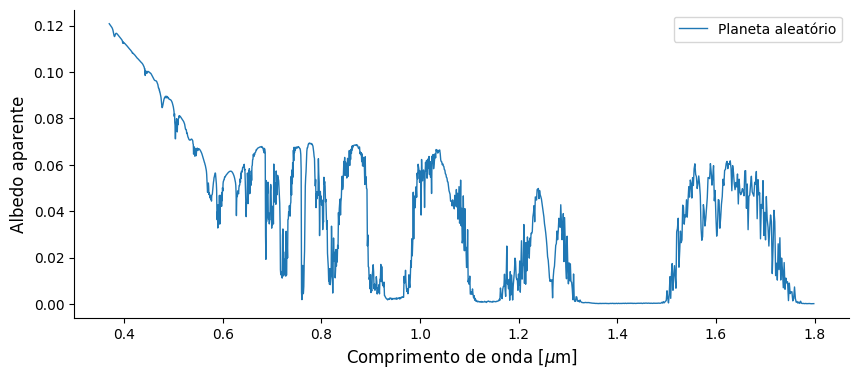

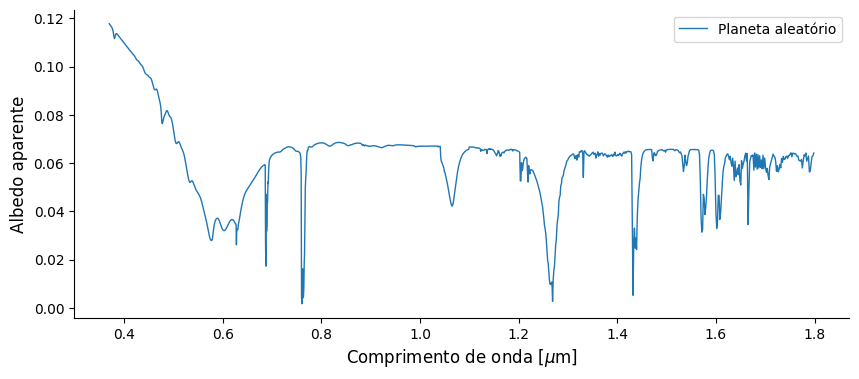

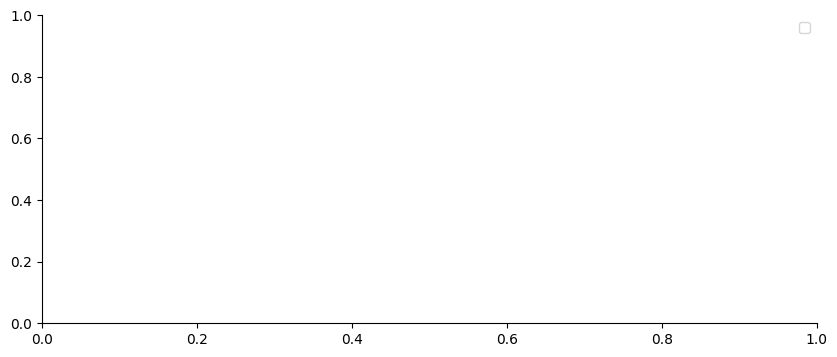

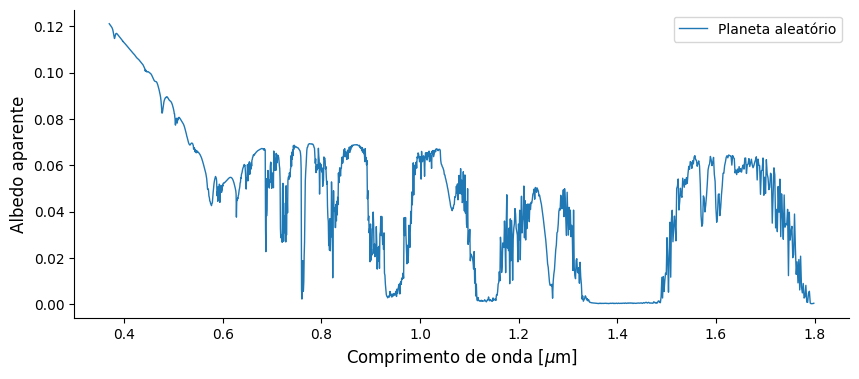

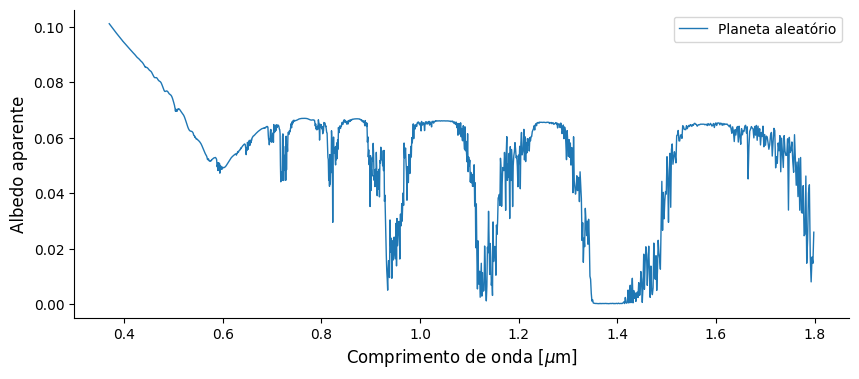

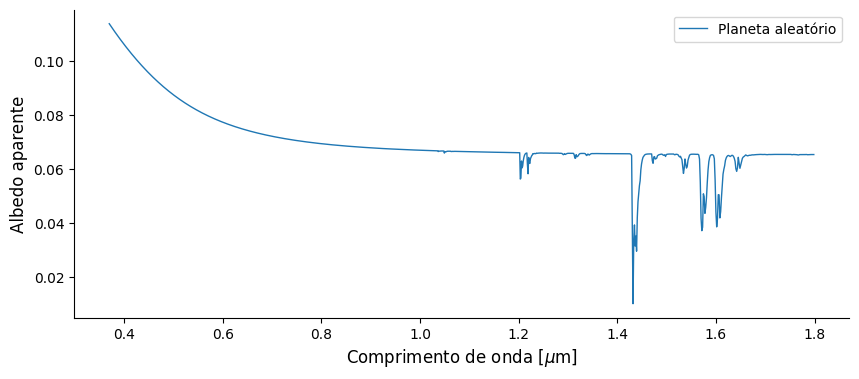

In [29]:
for aleatorio in range(20):
    aleatorio = config.copy()
    config_aleatorio(aleatorio, mod_telescopio = True)
    resultado_random = psg.run(aleatorio)

    spectrum_random = EspectroAnalise(resultado_random)

    _, ax = plt.subplots()
    spectrum_random.plotar_espectro(ax = ax, label = "Planeta aleatório", cor_linha = "tab:blue")
    # spectrum.plotar_espectro(ax = ax, label = "Terra Moderna", cor_linha = "black")
    ax.legend();